<a href="https://colab.research.google.com/github/Amin5555/arabic-minst-CNN/blob/main/CNN___ARABIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python packages to manipulate files
import os
import pathlib
from pathlib import Path
import datetime
# Tensorflow and Numpy packages
import tensorflow as tf
import numpy as np

# Display related packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import PIL
import PIL.Image

%matplotlib inline

In [2]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
# #tf.config.set_visible_devices([], 'GPU')

In [3]:
! git clone https://github.com/minus--/arabic-letters-tutorial.git

Cloning into 'arabic-letters-tutorial'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 50 (delta 25), reused 31 (delta 12), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [4]:
! [ ! -d ./data ] && tar xvzf ./arabic-letters-tutorial/arabic_handwritten_data.tgz || echo "Dataset folder already exists"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
data/train_data/id_8608_label_12.png
data/train_data/id_2106_label_12.png
data/train_data/id_10590_label_8.png
data/train_data/id_2818_label_17.png
data/train_data/id_7349_label_23.png
data/train_data/id_5289_label_18.png
data/train_data/id_3050_label_18.png
data/train_data/id_11114_label_18.png
data/train_data/id_192_label_24.png
data/train_data/id_6258_label_27.png
data/train_data/id_6579_label_11.png
data/train_data/id_9058_label_13.png
data/train_data/id_10945_label_25.png
data/train_data/id_8889_label_20.png
data/train_data/id_4557_label_10.png
data/train_data/id_5785_label_24.png
data/train_data/id_5074_label_19.png
data/train_data/id_7812_label_25.png
data/train_data/id_12978_label_27.png
data/train_data/id_325_label_13.png
data/train_data/id_9146_label_24.png
data/train_data/id_5488_label_14.png
data/train_data/id_7108_label_21.png
data/train_data/id_9379_label_25.png
data/train_data/id_3045_label_17.

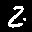

In [5]:
Image(filename = "data/test_data/id_10_label_5.png", width = 32, height = 32)

In [6]:
directory = "./data/train_data/"
images = os.listdir(directory)

In [7]:
images[0:12]

['id_2641_label_23.png',
 'id_12376_label_7.png',
 'id_4378_label_16.png',
 'id_8805_label_9.png',
 'id_3454_label_12.png',
 'id_3407_label_6.png',
 'id_2538_label_10.png',
 'id_3747_label_21.png',
 'id_329_label_14.png',
 'id_10604_label_10.png',
 'id_4938_label_2.png',
 'id_11921_label_7.png']

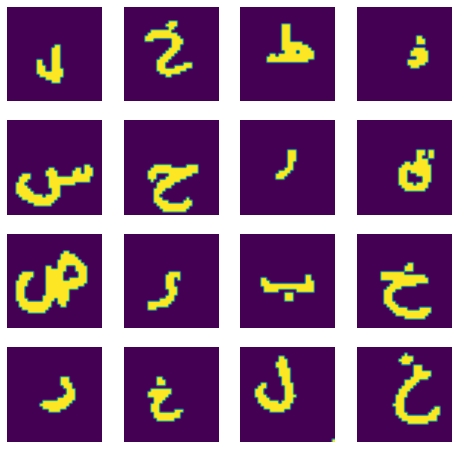

In [8]:
ncols = 4
nrows = 4

fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

for i, img_path in enumerate(images[0:ncols*nrows]):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Disable axes display

    img = mpimg.imread(directory+img_path)
    plt.imshow(img)

plt.show()

In [9]:
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

In [10]:
arabic_char_utf8 = ("أ","ب","ت","ث","ج","ح","خ","د","ذ","ر","ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي")

In [11]:
len(arabic_characters)

28

In [12]:
arabic_characters[12]

'sheen'

In [13]:
arabic_char_utf8[12]

'ش'



# **Load the data**
We process the folder and load each files in it.

We extract the label of each picture and convert the image to a rescaled matrix of 32x32x3.


In [14]:
batch_size = 32
img_height = 32
img_width = 32

def get_dataset(dataset_dir):
    
    def process_filename(file_path):
        label = tf.strings.regex_replace(input=file_path,pattern=r".+_label_(\d+)\.png", rewrite=r"\1")
        label = tf.strings.to_number(label, tf.int32)-1
        #label = tf.one_hot(label, depth=29)
        return label

    def process_img(file_path):

        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, size=(32, 32))
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255.0
        return img
    
    data_dir = pathlib.Path(dataset_dir)
    file_list = [str(path.absolute()) for path in Path(data_dir).glob("*.png")]
    files_ds = tf.data.Dataset.from_tensor_slices((file_list))
    files_ds = files_ds.map(lambda x: (process_img(x), process_filename(x)))
    return files_ds

In [15]:
train_dataset_path = "data/train_data"
test_dataset_path = "data/test_data"

train_ds = get_dataset(train_dataset_path).shuffle(buffer_size=batch_size*10).batch(batch_size)
valid_ds = get_dataset(test_dataset_path).batch(batch_size)

Utiliser ImageDataGenerator pour loader le dataset en changeant la structure des répertoires du dataset + data augmentation :

In [16]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D 
from keras.optimizers import RMSprop 
from keras.preprocessing.image import ImageDataGenerator 
import shutil,sys

In [17]:
mkdir data/data_arabic

In [18]:
mkdir data/data_arabic/test_data

In [19]:
mkdir data/data_arabic/train_data

In [20]:
for i in range(1,29):
  os.mkdir("data/data_arabic/test_data/{}".format(i))
  os.mkdir("data/data_arabic/train_data/{}".format(i))

In [21]:
directory_train = "./data/train_data/"
images_train = os.listdir(directory_train)
directory_test = "./data/test_data/"
images_test = os.listdir(directory_test)

In [22]:
for image in images_train:
  if image.endswith('.png'):
    label =int(tf.strings.regex_replace(input=image,pattern=r".+_label_(\d+)\.png",rewrite =r"\1").numpy())
    original = directory_train+image
    target =("./data/data_arabic/train_data/{}/".format(label))+image
    shutil.copy2(original,target)

In [23]:
for image in images_test:
  if image.endswith('.png'):
    label =int(tf.strings.regex_replace(input=image,pattern=r".+_label_(\d+)\.png",rewrite =r"\1").numpy())
    original = directory_test+image
    target =("./data/data_arabic/test_data/{}/".format(label))+image
    shutil.copy2(original,target)

In [24]:
train_dataset = "data/data_arabic/train_data"
test_dataset = "data/data_arabic/test_data"

In [25]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True ,vertical_flip=True)

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
train_generator = train_datagen.flow_from_directory(
        train_dataset,
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        test_dataset,
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')

Found 13440 images belonging to 28 classes.
Found 3360 images belonging to 28 classes.


Changer le Dense neural network par un Deep Convolutional Network : 

In [29]:

model = tf.keras.models.Sequential([
    # Couche1
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32, 32, 3)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    #Couche2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
   


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(28,activation='softmax')
])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

Training 


In [30]:
model.compile(
    # Optimizer
    optimizer=tf.keras.optimizers.RMSprop(),  
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [31]:
print("Fit model on training data")
history = model.fit(train_ds, epochs = 50, validation_data=valid_ds)

Fit model on training data
Epoch 1/50
420/420 [==============================] - 49s 116ms/step - loss: 3.1539 - sparse_categorical_accuracy: 0.2385 - val_loss: 3.0596 - val_sparse_categorical_accuracy: 0.3342
Epoch 2/50
420/420 [==============================] - 44s 105ms/step - loss: 3.0529 - sparse_categorical_accuracy: 0.3394 - val_loss: 3.0229 - val_sparse_categorical_accuracy: 0.3685
Epoch 3/50
420/420 [==============================] - 44s 104ms/step - loss: 3.0203 - sparse_categorical_accuracy: 0.3719 - val_loss: 3.0069 - val_sparse_categorical_accuracy: 0.3863
Epoch 4/50
420/420 [==============================] - 44s 104ms/step - loss: 3.0014 - sparse_categorical_accuracy: 0.3900 - val_loss: 2.9908 - val_sparse_categorical_accuracy: 0.4003
Epoch 5/50
420/420 [==============================] - 44s 105ms/step - loss: 2.9876 - sparse_categorical_accuracy: 0.4046 - val_loss: 2.9685 - val_sparse_categorical_accuracy: 0.4235
Epoch 6/50
420/420 [==============================] - 45s 

Training (augmented data)

In [32]:
model.compile(
    loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']
)

In [33]:
history = model.fit(train_generator, epochs = 50, verbose=1,validation_data=validation_generator)

Epoch 1/50
420/420 [==============================] - 49s 116ms/step - loss: 3.9498 - accuracy: 0.2018 - val_loss: 1.7284 - val_accuracy: 0.4634
Epoch 2/50
420/420 [==============================] - 48s 115ms/step - loss: 1.8032 - accuracy: 0.4349 - val_loss: 1.2118 - val_accuracy: 0.5949
Epoch 3/50
420/420 [==============================] - 49s 116ms/step - loss: 1.4558 - accuracy: 0.5423 - val_loss: 1.1277 - val_accuracy: 0.6396
Epoch 4/50
420/420 [==============================] - 49s 116ms/step - loss: 1.2443 - accuracy: 0.6048 - val_loss: 0.9635 - val_accuracy: 0.7027
Epoch 5/50
420/420 [==============================] - 48s 115ms/step - loss: 1.1229 - accuracy: 0.6461 - val_loss: 0.7217 - val_accuracy: 0.7708
Epoch 6/50
420/420 [==============================] - 49s 117ms/step - loss: 1.0206 - accuracy: 0.6746 - val_loss: 0.8216 - val_accuracy: 0.7396
Epoch 7/50
420/420 [==============================] - 48s 115ms/step - loss: 0.9722 - accuracy: 0.6882 - val_loss: 0.8366 - val_ac

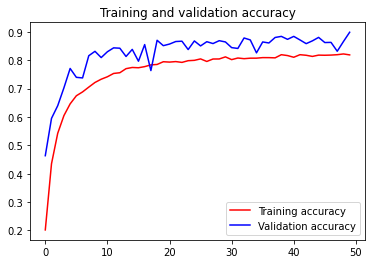

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

En se basant sur l'accuracy et la fonction de cout , la courbe de training oscillé avec la courbe de validation , notre choix des layers ne donne pas des bonnes résultats (par rapport au ANN) c'est pour ça qu'il faut peut etre refaire le choix des layers .

**interpretation** : 
- d'apres les resultats obtenues nous avons eu une accuracy de pres de 50% pour le raw data et plus de 80% pour le augmented data 

- dans le cas de CNN que ce soit pour le raw data et pour le data augmented les résultats sont mauvaises par rapport au ANN qui a donné une accuracy de plus de 90% supérieur à celle de CNN .

 **Conclusion** :
 dans le cas de Arabic minst il est recommandé d'opter la méthode ANN .

  